Simulation completed


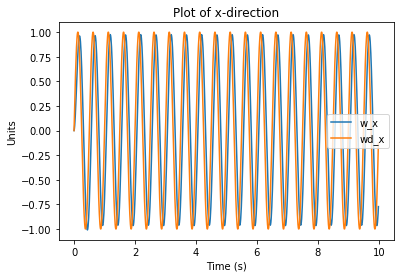

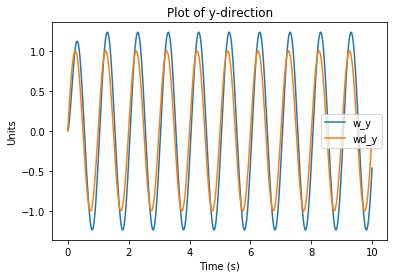

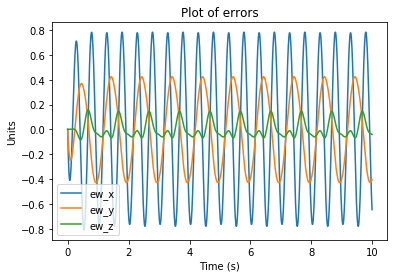

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt

J = np.array ([[8,0,0],
               [0,8,0],
               [0,0,8]])
# randomly selected values for gains - checked by trial and error
Kp = 500
Kd = 100

def calculateOmegaError(curr_omega, des_omega, R, R_desired):
    Rt = np.transpose(R)
    error = curr_omega - np.dot(np.dot(Rt, R_desired), des_omega)
    return error

def calculateRotationalError(R, R_desired):
    error = (R_desired.transpose().dot(R) - R.transpose().dot(R_desired))/2
    return error

def getVeeMap(matrix):
    vector = np.array([
        matrix[2][1],
        matrix[0][2],
        matrix[1][0]])
    return vector

def getHatMap(vector):
    matrix = np.array(
        [[0, -vector[2], vector[1]],
         [vector[2], 0, -vector[0]],
         [-vector[1], vector[0], 0]])
    return matrix

def calculateControlInput(errorRotational, errorOmega, Kp, Kd):
    U = - Kp*getVeeMap(errorRotational) - Kd*errorOmega
    return U

def calculateTargetRotation(omega, R_desired):
    return solveRodriguesEquation(omega).dot(R_desired)

def solveRodriguesEquation(W):
    (theta, direction) = findDirectionAndNorm(step*W)
    K = getHatMap(direction)
    answer = I + np.sin(theta)*K + (1-np.cos(theta))*np.dot(K,K)
    return answer

def findDirectionAndNorm(vector):
    norm = np.linalg.norm(vector)
    if norm==0:
        return [0, np.array([0,0,0])]
    unit_vector = vector/norm
    return (norm, unit_vector)

def simulationStepOmega(U, J, omega):
    RHS = np.cross(J.dot(omega), omega) + U
    J_inverse = np.linalg.inv(J)
    omega_dot = J_inverse.dot(RHS)
    return omega_dot*step + omega

I = np.identity(3)
start = 0
end = 10
step = 0.01
times = np.arange(start, end, step)
R = np.identity(3)
omega = np.array([0,0,0])
R_desired = R
f=2
count=0
omegasDesired = [np.array([np.sin(2*np.pi*f*time), np.sin(2*np.pi*f*0.5*time), 0]) for time in times]

tracked_W = []
tracked_Wd = []
tracked_ew = []

for (time, omegaDesired) in zip(times, omegasDesired):
    R_desired = calculateTargetRotation(omegaDesired, R_desired)
    errorOmega = calculateOmegaError(omega, omegaDesired, R, R_desired)
    errorRotational = calculateRotationalError(R, R_desired)
    U = calculateControlInput(errorRotational, errorOmega, Kp, Kd)
    newOmega = simulationStepOmega(U, J, omega)
    R = solveRodriguesEquation(newOmega).dot(R)
    omega = newOmega
#     print(time, omega, omegaDesired)
    tracked_W.append(omega)
    tracked_Wd.append(omegaDesired)
    tracked_ew.append(omega-omegaDesired)
    
tracked_W = np.asarray(tracked_W)
tracked_Wd = np.asarray(tracked_Wd)
tracked_ew = np.asarray(tracked_ew)

print("Simulation completed")

plt.plot(times,tracked_W[:,0], label='w_x')
plt.plot(times,tracked_Wd[:,0],  label='wd_x')
plt.legend()
plt.title("Plot of x-direction")
plt.xlabel("Time (s)")
plt.ylabel("Units")
plt.savefig("plots/wx.png")
plt.show()

plt.plot(times, tracked_W[:,1], label='w_y')
plt.plot(times,tracked_Wd[:,1], label='wd_y')
plt.legend()
plt.title("Plot of y-direction")
plt.xlabel("Time (s)")
plt.ylabel("Units")
plt.savefig("plots/wy.png")
plt.show()

plt.plot(times, tracked_ew[:,0], label='ew_x')
plt.plot(times, tracked_ew[:,1],  label='ew_y')
plt.plot(times,tracked_ew[:,2],  label='ew_z')
plt.title("Plot of errors")
plt.xlabel("Time (s)")
plt.ylabel("Units")
plt.legend()
plt.savefig("plots/errors.png")
plt.show()
